# Benchmark Model

**Purpose of script:**

Define a benchmark model for performance comparisons

### Data Prep

Imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from functions import read_and_prep_parquet
from functions import get_rmse

Relevant paths:

In [2]:
df_path = r"../Data/combined/pandas_extended"

Import and prep data:

In [171]:
X_train, y_train = read_and_prep_parquet(df_path + 'melt_2019-07-02_extended.parquet.gzip', 'train')
X_test, y_test = read_and_prep_parquet(df_path + 'melt_2019-07-02_extended.parquet.gzip', 'test')


## Baseline models

### Baseline Regression

In [172]:
y_predicted = np.full((1, len(y_test)), y_train.mean())[0]

In [173]:
rmse2 = get_rmse(y_test, y_predicted)

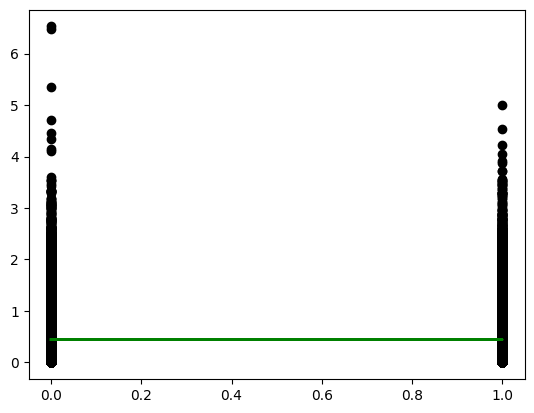

In [174]:
plt.scatter(X_test['mw_value'], y_test,  color='black')
plt.plot(X_test['mw_value'], y_predicted, color='green', linewidth=2)

### Baseline Classification

In [175]:
# melt threshold in paper - 0.64
print(f'melt percent in opt data {(y_train >= 0.64).sum()/len(y_train)}')
print(f'melt percent in mw data {(X_train["mw_value"] == 1).sum()/len(X_train)}')

melt percent in opt data opt_value    0.226737
dtype: float64
melt percent in mw data 0.3692793276685716


In [176]:
# X_train['opt_value'] = y_train

# fig, axes = plt.subplots(ncols=2, figsize=(8,5))
# axes[0].hist(X_train[X_train['mw_value'] == 1]['opt_value'])
# axes[1].hist(X_train[X_train['mw_value'] == 0]['opt_value'])

# plt.draw()

#### Binary classification

predict majority class

In [177]:
y_predicted = np.full((1, len(y_test)), 0)[0]
y_test_classes = [1 if i >= 0.64 else 0 for i in y_test['opt_value']]

In [178]:
accuracy = accuracy_score(y_test_classes, y_predicted)
accuracy


0.7744204879036339

#### Multiclass (buckets) classification

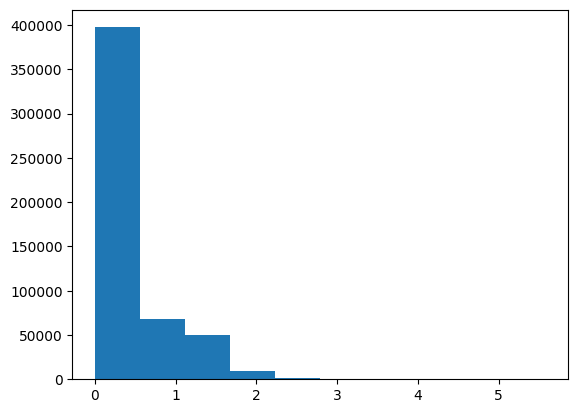

In [179]:
#plt.hist(df['opt_value'])
plt.hist(y_train);

11 buckets every 0.2 and all over 2

In [180]:
#X_train['opt_value'] = y_train


In [181]:
y_train['binned_opt_value'] = pd.cut(y_train['opt_value'], 
                                    list(np.arange(0, 0.41, 0.2)) 
                                    + [0.64] 
                                    + list(np.arange(0.8, 2.01, 0.2)) 
                                    + [7.0])

buckets = list(y_train['binned_opt_value'].unique())
buckets.sort()
num_buckets = len(buckets)
value_bucket_lookup = dict(zip(buckets, range(num_buckets)))
y_train['binned_opt_value_code'] = y_train['binned_opt_value'].replace(value_bucket_lookup).values

In [182]:
# find largest bucket and predict for all that
y_train['binned_opt_value_code'].value_counts()
# largest - bin 1


1     220471
0     151435
2      35513
4      24803
6      21424
5      21298
3      20088
7      16305
8       9032
9       3305
10      3209
Name: binned_opt_value_code, dtype: int64

In [183]:
# same for test
y_test['binned_opt_value'] = pd.cut(y_test['opt_value'], 
                                    list(np.arange(0, 0.41, 0.2)) 
                                    + [0.64] 
                                    + list(np.arange(0.8, 2.01, 0.2)) 
                                    + [7.0])

buckets_test = list(y_test['binned_opt_value'].unique())
buckets_test.sort()
num_buckets_test = len(buckets_test)
value_bucket_lookup_test = dict(zip(buckets_test, range(num_buckets_test)))
y_test['binned_opt_value_code'] = y_test['binned_opt_value'].replace(value_bucket_lookup_test).values

In [184]:
# predict
y_predicted = np.full((1, len(y_test)), 1)[0]

accuracy = accuracy_score(y_test['binned_opt_value_code'], y_predicted)
accuracy

0.4209497418767082